In [2]:
import matplotlib.pyplot as plt
#import pyspeckit 

from astropy.io import fits
from astropy.wcs import WCS

from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np

from spectral_cube import SpectralCube
from spectral_cube import Projection

from specutils import Spectrum1D
from specutils.manipulation import extract_region
from specutils.manipulation import noise_region_uncertainty
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.fitting import find_lines_threshold
import specutils
from specutils.fitting import fit_lines

import regions


In [3]:
print('test')

test


In [4]:
pos_cloudc1 = SkyCoord('17:46:21.3048683891', '-28:35:33.1211282499', unit=(u.hourangle, u.deg))
pos_cloudc2 = SkyCoord('17:46:18.3316118680', '-28:34:48.4717811920', unit=(u.hourangle, u.deg))
pos_cloudd = SkyCoord('17:46:22.6563371259', '-28:33:27.5405071803', unit=(u.hourangle, u.deg))
pos_filament = SkyCoord('17:46:20.9063719501', '-28:37:51.6942550990', unit=(u.hourangle, u.deg))

In [5]:
rad_cloudc1 = 15*u.arcsec
rad_cloudc2 = 15*u.arcsec
rad_cloudd = 30*u.arcsec
rad_filament = 1.5*u.arcmin

In [6]:
def plot_spectrum(spectrum, ax=None, **kwargs):
    if ax == None:
        ax = plt.subplot(111)
    ax.step(spectrum.spectral_axis.to(u.km/u.s), spectrum.flux, where='mid', **kwargs)
    ax.set_xlabel("Velocity ("+str(spectrum.spectral_axis.to(u.km/u.s).unit)+")")
    ax.set_ylabel("Brightness Temperature ("+str(spectrum.flux.unit)+")")
    return ax

In [7]:
def get_cutout(filename, position, l, w):
    try: 
        hdu = fits.open(filename, ext='SCI')[0]
    except: 
        hdu = fits.open(filename)[0]
    data = hdu.data
    head = hdu.header

    ww = WCS(head)
    size = (l, w)

    cutout = Cutout2D(data, position=position, size=size, wcs=ww)
    return cutout

def get_cutout_405(position, l, w):
    fn = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    return get_cutout(fn, position, l, w)

def get_cutout_circ(position, rad):
    fn = '/orange/adamginsburg/jwst/cloudc/images/F405_reproj_merged-fortricolor.fits'
    return get_cutout(fn, position, 3*rad, 3*rad)

# Cloud C1 Spectrum

## HNCO

In [8]:
spectrum_cloudc1 = Spectrum1D.read('/orange/adamginsburg/jwst/cloudc/alma/spectra/spectrum_cloudc1.fits')

Text(0, 0.5, 'Brightness Temperature (K)')

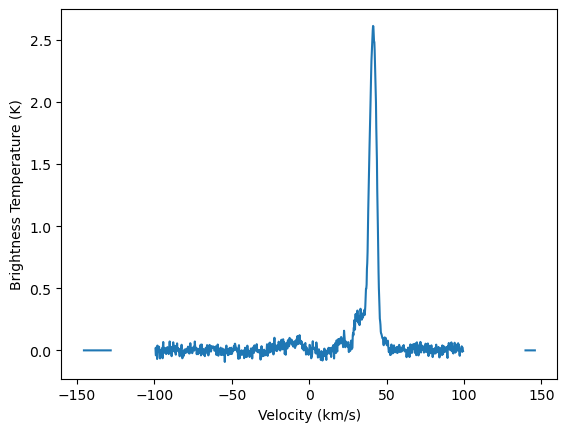

In [9]:
ax = plt.subplot(111)
ax.plot(spectrum_cloudc1.spectral_axis.to(u.km/u.s), spectrum_cloudc1.flux)

ax.set_xlabel('Velocity (km/s)')
ax.set_ylabel('Brightness Temperature (K)')

In [10]:
spectrum = spectrum_cloudc1

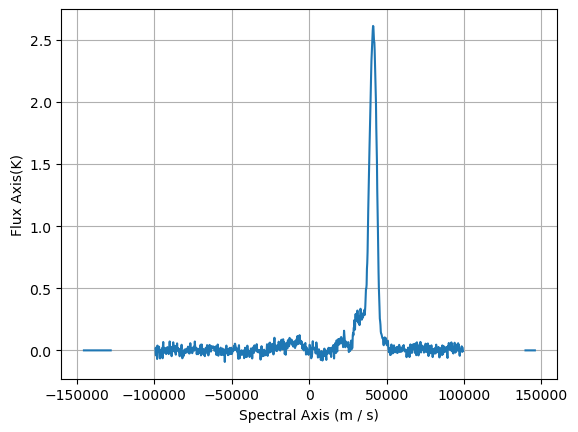

In [11]:
from matplotlib import pyplot as plt
plt.plot(spectrum.spectral_axis, spectrum.flux) 
plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit)) 
plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit)) 
plt.grid(True)

In [12]:
noise_region = SpectralRegion(50*u.km/u.s, 99*u.km/u.s)
spectrum = noise_region_uncertainty(spectrum, noise_region)

In [13]:
lines = find_lines_threshold(spectrum, noise_factor=3)  
lines[lines['line_type'] == 'emission']  


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
m / s,,
float64,str10,int64
-22484.08044,emission,591
-17903.989980000002,emission,613
-16863.06033,emission,618
-13740.27138,emission,633
-12699.34173,emission,638
-11450.22615,emission,644
-8119.251270000001,emission,660
-7494.693480000001,emission,663


(0.0, 75.0)

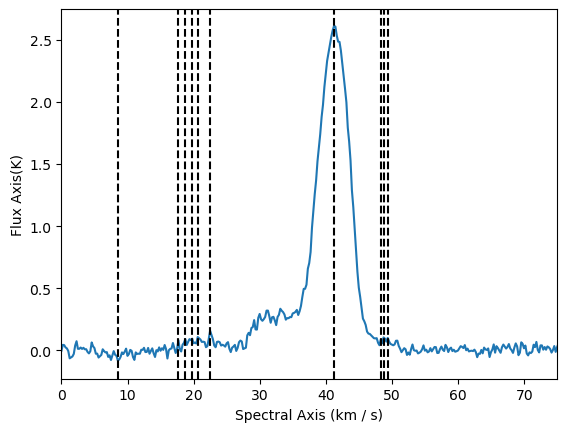

In [14]:
from matplotlib import pyplot as plt
ax = plt.subplot(111)
ax.plot(spectrum.spectral_axis.to(u.km/u.s), spectrum.flux) 
ax.set_xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.to(u.km/u.s).unit)) 
ax.set_ylabel('Flux Axis({})'.format(spectrum.flux.unit)) 

for line in lines:
    ax.axvline(line['line_center'].to(u.km/u.s).value, color='k', linestyle='--')

ax.set_xlim(left=0, right=75)

In [15]:
g_init = models.Gaussian1D(amplitude=2.5*u.K, mean=40*u.km/u.s, stddev=10*u.km/u.s)
g_fit = fit_lines(spectrum, g_init)
y_fit = g_fit(spectrum.spectral_axis)

In [16]:
cutout_c1 = get_cutout_circ(pos_cloudc1, rad_cloudc1)
reg_c1 = regions.CircleSkyRegion(center=pos_cloudc1, radius=rad_cloudc1)

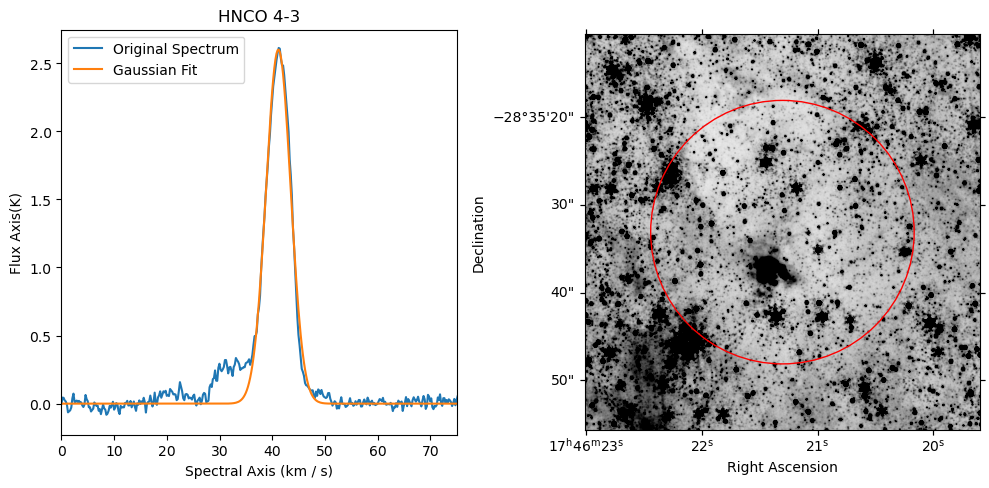

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax.plot(spectrum.spectral_axis.to(u.km/u.s), spectrum.flux, label='Original Spectrum') 
ax.plot(spectrum.spectral_axis.to(u.km/u.s), y_fit, label='Gaussian Fit')
ax.set_xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.to(u.km/u.s).unit)) 
ax.set_ylabel('Flux Axis({})'.format(spectrum.flux.unit)) 

ax.set_xlim(left=0, right=75)
ax.legend()
ax.set_title('HNCO 4-3')


ax1 = plt.subplot(122, projection=cutout_c1.wcs)
ax1.imshow(cutout_c1.data, cmap='Greys', vmin=0, vmax=25)
pix_reg = reg_c1.to_pixel(wcs=cutout_c1.wcs)
pix_reg.plot(color='r')
ax1.set_xlabel("Right Ascension")
ax1.set_ylabel("Declination")

plt.tight_layout()

In [18]:
g_fit

<Gaussian1D(amplitude=2.60075396 K, mean=41.15853699 km / s, stddev=2.3386304 km / s)>

In [19]:
specutils.analysis.fwhm(Spectrum1D(flux=y_fit, spectral_axis=spectrum.spectral_axis)).to(u.km/u.s)

<Quantity 5.50938254 km / s>

# Cloud C2 Spectrum

In [50]:
spectrum_cloudc2 = Spectrum1D.read('/orange/adamginsburg/jwst/cloudc/alma/spectra/spectrum_cloudc2.fits')

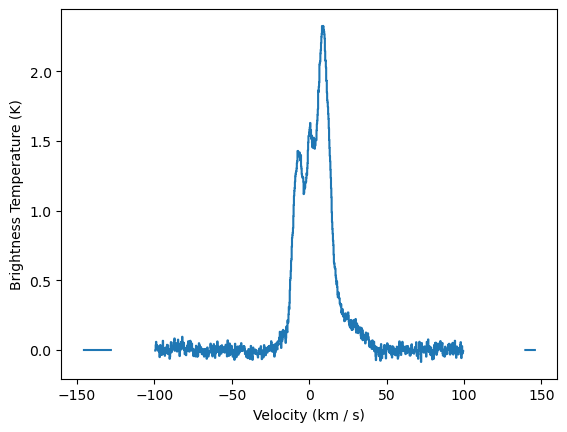

In [51]:
ax = plot_spectrum(spectrum_cloudc2)

In [52]:
noise_region = SpectralRegion(50*u.km/u.s, 99*u.km/u.s)
spectrum = noise_region_uncertainty(spectrum_cloudc2, noise_region)

In [53]:
lines = find_lines_threshold(spectrum, noise_factor=3)  
lines[lines['line_type'] == 'emission']  


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
m / s,,
float64,str10,int64
-82025.25642,emission,305
-19361.29149,emission,606
-18944.91963,emission,608
-18528.54777,emission,610
-17695.804050000002,emission,614
-16863.06033,emission,618
8951.994990000001,emission,742
34767.05031,emission,866


(-50.0, 75.0)

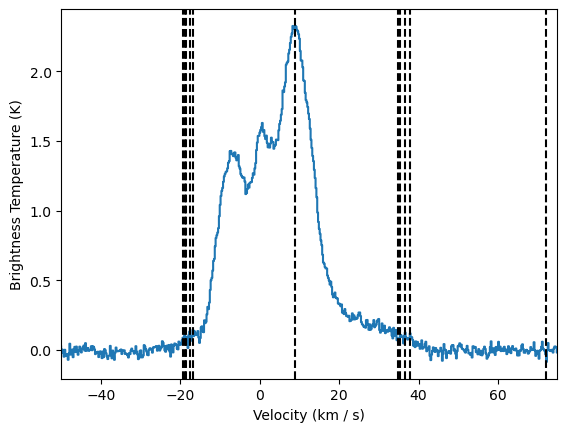

In [54]:
ax = plot_spectrum(spectrum_cloudc2)
for line in lines:
    ax.axvline(line['line_center'].to(u.km/u.s).value, color='k', linestyle='--')

ax.set_xlim(left=-50, right=75)

In [55]:
g1_init = models.Gaussian1D(amplitude=2.5*u.K, mean=10*u.km/u.s, stddev=5*u.km/u.s)
g2_init = models.Gaussian1D(amplitude=1.5*u.K, mean=0*u.km/u.s, stddev=5*u.km/u.s)
g3_init = models.Gaussian1D(amplitude=1.4*u.K, mean=-10*u.km/u.s, stddev=5*u.km/u.s)
g4_init = models.Gaussian1D(amplitude=1.4*u.K, mean=10*u.km/u.s, stddev=20*u.km/u.s)
g1234_fit = fit_lines(spectrum_cloudc2, g1_init+g2_init+g3_init+g4_init)
y_fit = g1234_fit(spectrum_cloudc2.spectral_axis)

In [56]:
cutout_c2 = get_cutout_circ(pos_cloudc2, rad_cloudc2)
reg_c2 = regions.CircleSkyRegion(center=pos_cloudc2, radius=rad_cloudc2)

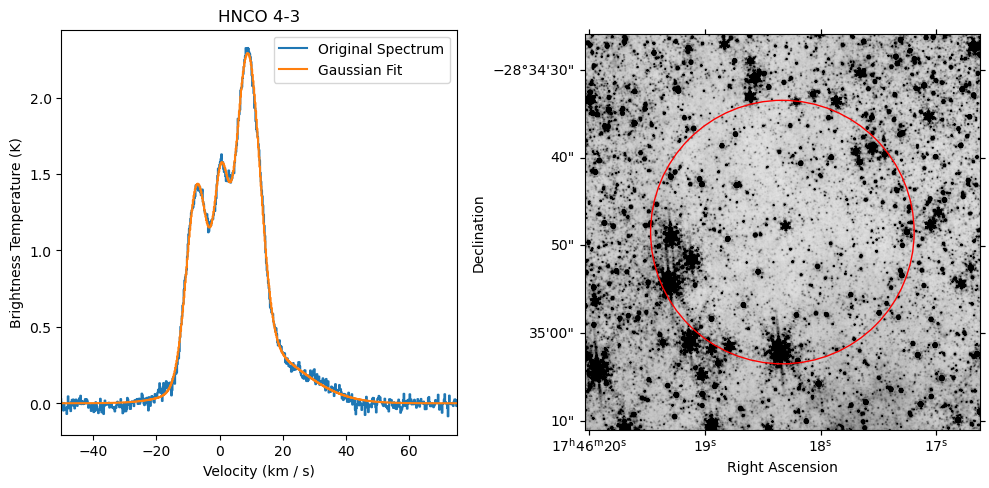

In [57]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = plot_spectrum(spectrum_cloudc2, ax=ax, label='Original Spectrum')
plot_spectrum(Spectrum1D(flux=y_fit, spectral_axis=spectrum_cloudc2.spectral_axis), ax=ax, label='Gaussian Fit')

ax.set_xlim(left=-50, right=75)
ax.legend()
ax.set_title('HNCO 4-3')


ax1 = plt.subplot(122, projection=cutout_c2.wcs)
ax1.imshow(cutout_c2.data, cmap='Greys', vmin=0, vmax=25)
pix_reg = reg_c2.to_pixel(wcs=cutout_c2.wcs)
pix_reg.plot(color='r')
ax1.set_xlabel("Right Ascension")
ax1.set_ylabel("Declination")

plt.tight_layout()

In [60]:
g1234_fit

<CompoundModel(amplitude_0=1.94181152 K, mean_0=8.87553068 km / s, stddev_0=3.88655708 km / s, amplitude_1=1.01743235 K, mean_1=0.41902262 km / s, stddev_1=2.22301534 km / s, amplitude_2=1.27556408 K, mean_2=-7.08183608 km / s, stddev_2=3.350781 km / s, amplitude_3=0.35273321 K, mean_3=11.263772 km / s, stddev_3=14.31634487 km / s)>

In [61]:
g1234_fit.stddev_0*2

<Quantity 7.77311415 km / s>

# Spectrum Cloud D

In [28]:
spectrum_cloudd = Spectrum1D.read('/orange/adamginsburg/jwst/cloudc/alma/spectra/spectrum_cloudd.fits')

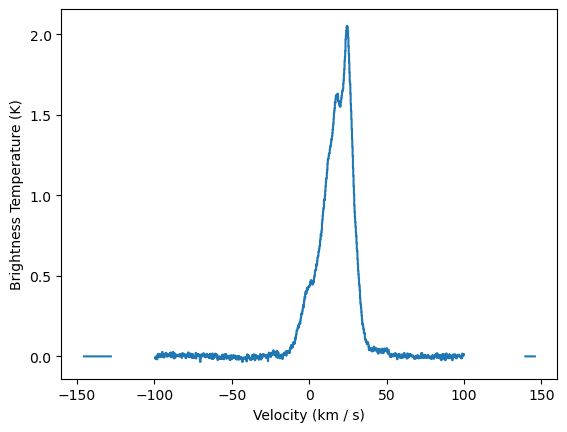

In [29]:
ax = plot_spectrum(spectrum_cloudd)

In [30]:
noise_region = SpectralRegion(50*u.km/u.s, 99*u.km/u.s)
spectrum = noise_region_uncertainty(spectrum_cloudd, noise_region)

In [31]:
lines = find_lines_threshold(spectrum, noise_factor=3)  
lines[lines['line_type'] == 'emission']  


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
m / s,,
float64,str10,int64
-23108.63823,emission,588
-21026.77893,emission,598
-13740.27138,emission,633
-13115.713590000001,emission,636
24357.753810000002,emission,816
41845.37193,emission,900
45592.71867,emission,918
47050.02018,emission,925


(-50.0, 75.0)

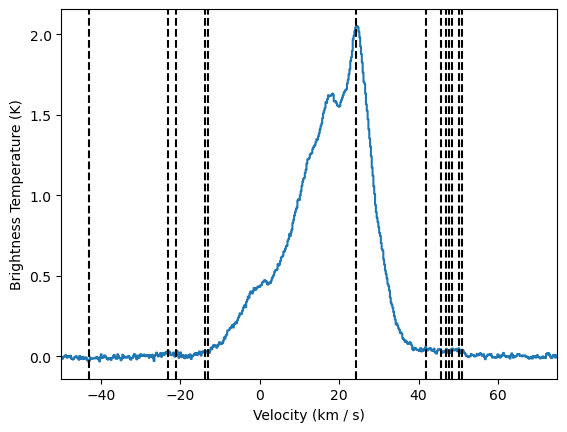

In [32]:
ax = plot_spectrum(spectrum_cloudd)
for line in lines:
    ax.axvline(line['line_center'].to(u.km/u.s).value, color='k', linestyle='--')

ax.set_xlim(left=-50, right=75)

In [33]:
g1_init = models.Gaussian1D(amplitude=2*u.K, mean=25*u.km/u.s, stddev=5*u.km/u.s)
g2_init = models.Gaussian1D(amplitude=1.7*u.K, mean=18*u.km/u.s, stddev=10*u.km/u.s)
g3_init = models.Gaussian1D(amplitude=0.5*u.K, mean=0*u.km/u.s, stddev=10*u.km/u.s)
#g4_init = models.Gaussian1D(amplitude=1.25*u.K, mean=15*u.km/u.s, stddev=10*u.km/u.s)
g1234_fit = fit_lines(spectrum_cloudd, g1_init+g2_init+g3_init)#+g4_init)
y_fit = g1234_fit(spectrum_cloudd.spectral_axis)

In [34]:
cutout_d = get_cutout_circ(pos_cloudd, rad_cloudd)
reg_d = regions.CircleSkyRegion(center=pos_cloudd, radius=rad_cloudd)

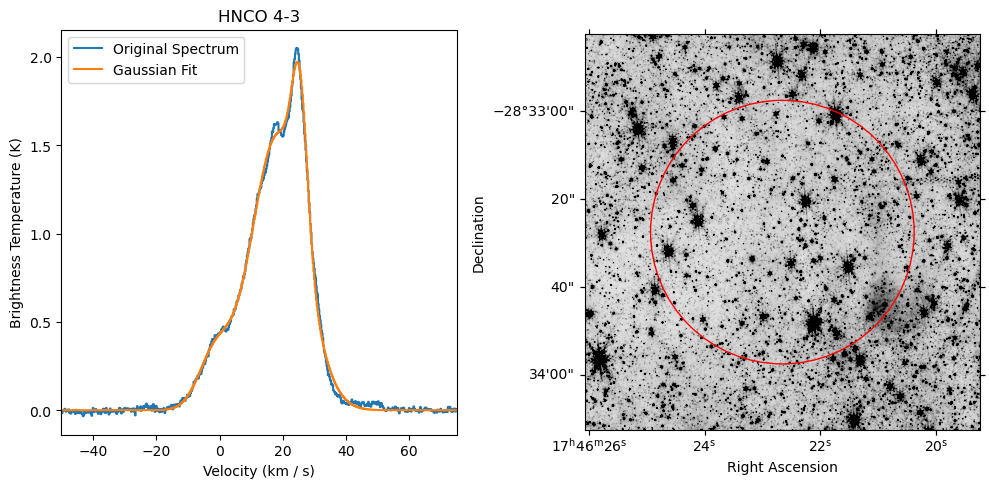

In [35]:
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
ax = plot_spectrum(spectrum_cloudd, ax=ax, label='Original Spectrum')
plot_spectrum(Spectrum1D(flux=y_fit, spectral_axis=spectrum_cloudd.spectral_axis), ax=ax, label='Gaussian Fit')

ax.set_xlim(left=-50, right=75)
ax.legend()
ax.set_title('HNCO 4-3')

ax1 = plt.subplot(122, projection=cutout_d.wcs)
ax1.imshow(cutout_d.data, cmap='Greys', vmin=0, vmax=25)
pix_reg = reg_d.to_pixel(wcs=cutout_d.wcs)
pix_reg.plot(color='r')
ax1.set_xlabel("Right Ascension")
ax1.set_ylabel("Declination")


plt.tight_layout()

In [36]:
g1234_fit.mean_0, g1234_fit.mean_1, g1234_fit.mean_2#, g1234_fit.mean_3

(Parameter('mean', value=25.371993893682408, unit=km / s),
 Parameter('mean', value=18.381721870626816, unit=km / s),
 Parameter('mean', value=-1.4799335405454885, unit=km / s))

In [37]:
g1234_fit.stddev_0*2, g1234_fit.stddev_1*2, g1234_fit.stddev_2*2#, g1234_fit.stddev_3

(<Quantity 4.85854755 km / s>,
 <Quantity 16.88551122 km / s>,
 <Quantity 10.37776039 km / s>)

# Filament

## CO

In [38]:
spectrum_filament_co = Spectrum1D.read('/orange/adamginsburg/jwst/cloudc/alma/spectra/spectrum_filament_12CO-BEARS.fits')

(-100.0, 0.0)

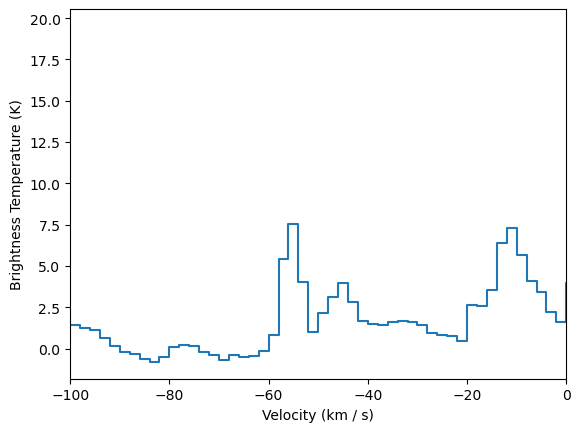

In [39]:
ax = plot_spectrum(spectrum_filament_co, label='12CO-BEARS')
ax.set_xlim(left=-100, right=0)

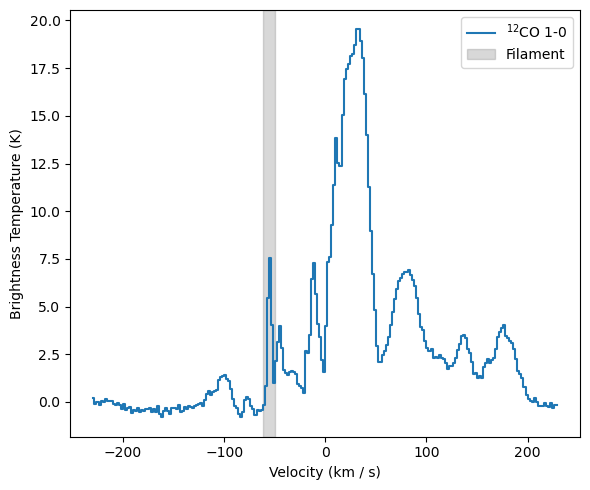

In [40]:
fig = plt.figure(figsize=(6, 5))#, dpi=250)
ax = plt.subplot(111)
ax = plot_spectrum(spectrum_filament_co, label=r'$^{12}$CO 1-0', ax=ax)
#ax.set_xlim(left=-100, right=100)
ax.axvspan(-62, -50, color='gray', alpha=0.3, label='Filament')
ax.legend()
plt.tight_layout()

#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_spectrum_12CO.pdf', bbox_inches='tight')

In [41]:
g1_init = models.Gaussian1D(amplitude=8*u.K, mean=-55*u.km/u.s, stddev=1*u.km/u.s)
g1234_fit = fit_lines(spectrum_filament_co, g1_init)
y_fit = g1234_fit(spectrum_filament_co.spectral_axis)

Text(0.5, 1.0, 'Filament CO 1-0')

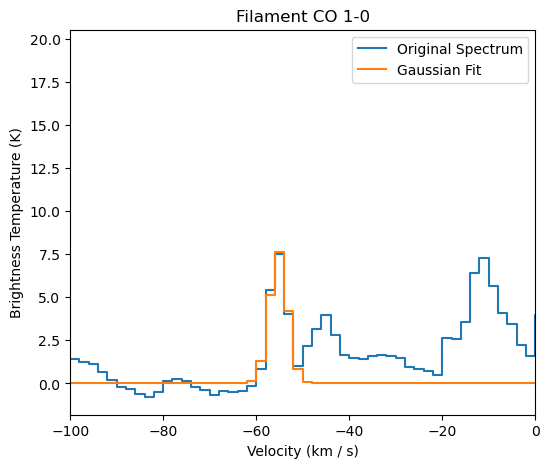

In [42]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax = plot_spectrum(spectrum_filament_co, ax=ax, label='Original Spectrum')
plot_spectrum(Spectrum1D(flux=y_fit, spectral_axis=spectrum_filament_co.spectral_axis), ax=ax, label='Gaussian Fit')

ax.set_xlim(left=-100, right=0)
ax.legend()
ax.set_title('Filament CO 1-0')

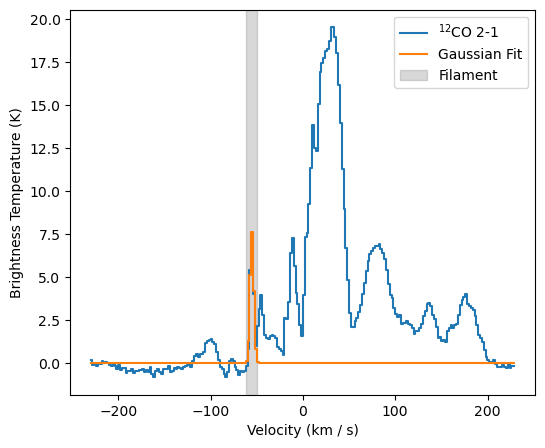

In [43]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax = plot_spectrum(spectrum_filament_co, ax=ax, label=r'$^{12}$CO 2-1')
plot_spectrum(Spectrum1D(flux=y_fit, spectral_axis=spectrum_filament_co.spectral_axis), ax=ax, label='Gaussian Fit')

#ax.set_xlim(left=-100, right=0)
ax.axvspan(-62, -50, color='gray', alpha=0.3, label='Filament')
ax.legend()
#ax.set_title('Filament CO 1-0')

In [44]:
g1234_fit.fwhm

<Quantity 4.74094866 km / s>

## HNCO

In [62]:
spectrum_filament_hnco = Spectrum1D.read('/orange/adamginsburg/jwst/cloudc/alma/spectra/spectrum_filament.fits')

(-0.02369157958429174, 0.05)

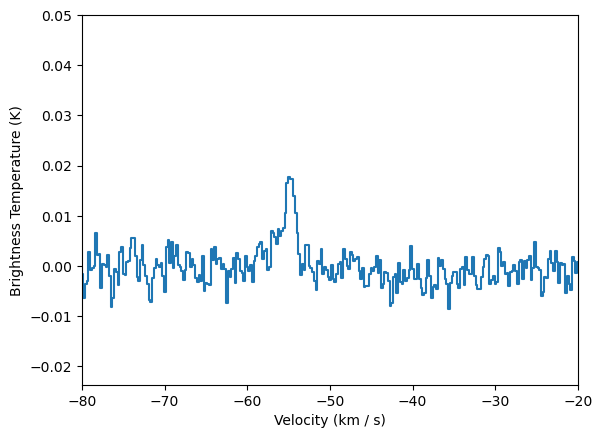

In [63]:
ax = plot_spectrum(spectrum_filament_hnco, label='HNCO 4-3')
ax.set_xlim(left=-80, right=-20)
ax.set_ylim(top=0.05)

In [64]:
g1_init = models.Gaussian1D(amplitude=0.2*u.K, mean=-55*u.km/u.s, stddev=1*u.km/u.s)
g1234_fit = fit_lines(spectrum_filament_hnco, g1_init)
y_fit = g1234_fit(spectrum_filament_hnco.spectral_axis)

Text(0.5, 1.0, 'Filament HNCO 4-3')

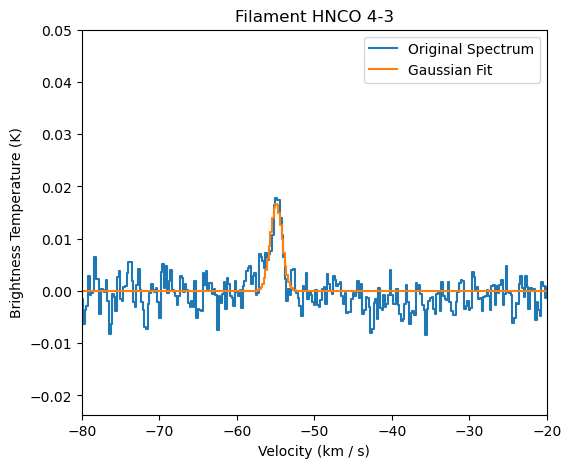

In [65]:
fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax = plot_spectrum(spectrum_filament_hnco, ax=ax, label='Original Spectrum')
plot_spectrum(Spectrum1D(flux=y_fit, spectral_axis=spectrum_filament_hnco.spectral_axis), ax=ax, label='Gaussian Fit')

ax.set_xlim(left=-80, right=-20)
ax.set_ylim(top=0.05)
ax.legend()
ax.set_title('Filament HNCO 4-3')

In [66]:
g1234_fit

<Gaussian1D(amplitude=0.01672109 K, mean=-54.91307625 km / s, stddev=0.76425166 km / s)>

In [67]:
g1234_fit.fwhm

<Quantity 1.79967512 km / s>